In [1]:
import jax.numpy as jnp
from jax import random, grad, jit, random

In [2]:
import kagglehub
import matplotlib.pyplot as plt
import numpy as np

# path = kagglehub.dataset_download("hojjatk/mnist-dataset")  # download mnist
path = '/home/tibless/.cache/kagglehub/datasets/hojjatk/mnist-dataset/versions/1'
key = random.PRNGKey(42)
print(f'mnsit at: {path}')

mnsit at: /home/tibless/.cache/kagglehub/datasets/hojjatk/mnist-dataset/versions/1


In [3]:
# load mnist

import os
import struct
import numpy as np

def read_idx(filename):
    """
    Read MNIST data from file using idx format.

    Return
    ------
    np.ndarray
    """
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

TRAIN = 60000
TEST  = 10000
train_images = read_idx(os.path.join(path, 'train-images.idx3-ubyte'))[:TRAIN]
train_labels = read_idx(os.path.join(path, 'train-labels.idx1-ubyte'))[:TRAIN]
test_images = read_idx(os.path.join(path, 't10k-images.idx3-ubyte'))[:TEST]
test_labels = read_idx(os.path.join(path, 't10k-labels.idx1-ubyte'))[:TEST]

shuffle_kernel = np.random.permutation(np.arange(TRAIN))
train_images = train_images[shuffle_kernel]
train_labels = train_labels[shuffle_kernel]

print("训练图像数据大小: ", train_images.shape)
print("训练标签数据大小: ", train_labels.shape)
print("测试图像数据大小: ", test_images.shape)
print("测试标签数据大小: ", test_labels.shape)

训练图像数据大小:  (60000, 28, 28)
训练标签数据大小:  (60000,)
测试图像数据大小:  (10000, 28, 28)
测试标签数据大小:  (10000,)


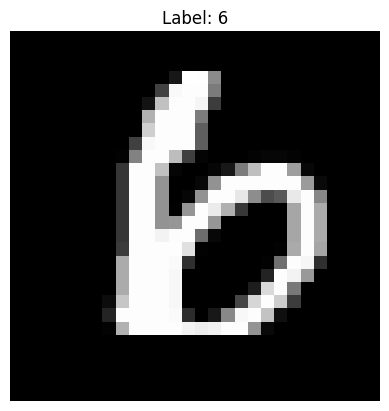

In [4]:
ix = 4
plt.imshow(train_images[ix], cmap='gray')
plt.title(f"Label: {train_labels[ix]}")
plt.axis('off')  # 不显示坐标轴
plt.show()

In [5]:
X_train = jnp.array(train_images.reshape(train_images.shape[0], -1)) / 255.  # normalization to accelerate training & convergency
y_train = jnp.array(train_labels)
X_test = jnp.array(test_images.reshape(test_images.shape[0], -1)) / 255.
y_test = jnp.array(test_labels)

def one_hot(y: jnp.ndarray, num_class: int):
    res = jnp.zeros((y.shape[0], num_class))
    res = res.at[jnp.arange(y.shape[0]), y].set(1)
    return res

y_train_one_hot = one_hot(y_train, 10)
y_test_one_hot = one_hot(y_test, 10)

In [6]:
from plugins.minitorch.optimizer import Adam
from plugins.minitorch.utils import softmax, cross_entropy_loss
from plugins.minitorch.initer import Initer
from plugins.minitorch.nn import dropout
from plugins.minitorch.loss import CrossEntropyLoss

class mlp_clf:
    def __init__(self, lr=0.01, batch_size=32):
        self.config = {
            'fc4relu:0' : {
                'input_dim': 28 * 28 * 1,
                'output_dim': 128,
            },
            'relu': {},
            'fc4relu:1' : {
                'input_dim': 128,
                'output_dim': 64,
            },
            'fc4relu:2' : {
                'input_dim': 64,
                'output_dim': 32,
            },
            'fc4relu:3' : {
                'input_dim': 32,
                'output_dim': 16,
            },
            'fc4relu:4' : {
                'input_dim': 16,
                'output_dim': 10,
            }
        }

        initer = Initer(self.config, key)
        self.optr = Adam(initer(), lr=lr, batch_size=batch_size)
        self.train = False

    def predict_proba(self, x: jnp.ndarray, params, train=False):
        '''
        这里train默认False是为了方便测试，不用手动eval。
        '''
        res = x
        key = random.PRNGKey(42)
        for p in params.values():
            # 这里建议使用这种从kv对直接访问的形式，而不是解引用，因为此时的字典顺序由于多线程的不正确同步访问而可能产生了乱序，比如这里：
            # >>>>>> print(p.keys())
            # >>>>>> w, b = p.values()
            # 如果你使用这个就会报错，因为之前使用JIT编译之后的函数包含了这个参数，就是说我写了一个函数，这个函数的其中一个参数是param，然后由于JIT的多线程优化，导致被编译之后执行时字典顺序变成：['b', 'w']
            # 因此如果你使用解绑定，那么你就会得到互换的w和b
            # 后面发现即使不使用JIT也会出现相同的问题，因为没有JIT也会有其它多线程的优化，导致这里发生问题。
            res = res @ p['w'] + p['b']  
            res = jnp.maximum(0, res)  # use relu activation function
            res, key = dropout(res, key, p=0.1, train=train)  # add dropout

        return softmax(res)


    def fit(self, x_train, y_train_proba, x_test, y_test_proba, epoches=100): 
        cnt = 0

        @jit
        def _acc(y_true_proba, y_pred_proba):
            y_true = jnp.argmax(y_true_proba, axis=1)
            y_pred = jnp.argmax(y_pred_proba, axis=1)
            return jnp.mean(y_true == y_pred)

        _loss = lambda params, x, y_true: cross_entropy_loss(y_true, self.predict_proba(x, params, True)) 
        _loss = jit(_loss)  # accelerate loss function by JIT
        self.optr.open(_loss, x_train, y_train_proba)
        
        _tloss = lambda params: cross_entropy_loss(y_test_proba, self.predict_proba(x_test, params, False)) 
        _tloss = jit(_tloss)  # accelerate loss function by JIT
        

        acc, loss, tacc, tloss = [], [], [], []  # train acc, train loss, test acc, test loss

        for _ in range(epoches):
            loss.append(_loss(self.optr.get_params(), x_train, y_train_proba))
            tloss.append(_tloss(self.optr.get_params()))

            self.train = True  # use dropout only while updating grads
            self.optr.update()
            self.train = False
            
            acc.append(_acc(y_train_proba, self.predict_proba(x_train, self.optr.get_params())))
            tacc.append(_acc(y_test_proba, self.predict_proba(x_test, self.optr.get_params())))
            cnt += 1
            if cnt % 10 == 0:
                print(f'>> epoch: {cnt}, train acc: {acc[-1]}, test acc: {tacc[-1]}')

        return acc, loss, tacc, tloss

In [7]:
batch_size = 512
learning_rate = 0.015
epochs = 50

mlp = mlp_clf(lr=learning_rate, batch_size=batch_size)

acc, loss, tacc, tloss = mlp.fit(
    x_train=X_train, 
    y_train_proba=y_train_one_hot,
    x_test=X_test,
    y_test_proba=y_test_one_hot,
    epoches=epochs)

[*] oprimizer opened with 117 batches with batch size 512.
>> epoch: 10, train acc: 0.9760000109672546, test acc: 0.9657999873161316
>> epoch: 20, train acc: 0.9788333177566528, test acc: 0.9677000045776367
>> epoch: 30, train acc: 0.9811500310897827, test acc: 0.967799961566925
>> epoch: 40, train acc: 0.9741500020027161, test acc: 0.9633999466896057
>> epoch: 50, train acc: 0.9809666872024536, test acc: 0.9695999622344971


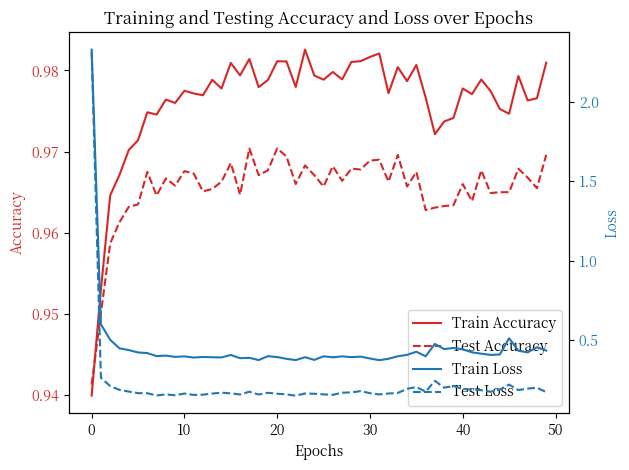

final train, test acc : 0.9809666872024536, 0.9695999622344971
final train, test loss: 0.43373560905456543, 0.17215603590011597


In [8]:
fig, ax1 = plt.subplots()

plt.rcParams['font.family'] = 'Noto Serif SC'
plt.rcParams['font.sans-serif'] = ['Noto Serif SC']

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(range(epochs), acc, color=color, label='Train Accuracy', linestyle='-')
ax1.plot(range(epochs), tacc, color=color, label='Test Accuracy', linestyle='--')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Loss', color=color)  
ax2.plot(range(epochs), loss, color=color, label='Train Loss', linestyle='-')
ax2.plot(range(epochs), tloss, color=color, label='Test Loss', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='lower right')

plt.title('Training and Testing Accuracy and Loss over Epochs')
fig.tight_layout()
# plt.savefig(f'./assets/mlp_batch:{batch_size}.svg', format='svg')
plt.show()

print(f'final train, test acc : {acc[-1]}, {tacc[-1]}')
print(f'final train, test loss: {loss[-1]}, {tloss[-1]}')